In [1]:
from operator import itemgetter
from collections import Counter

from PIL import Image, ImageFilter
from IPython.display import Image as imgp
import cv2, pytesseract
from matplotlib.pyplot import imshow

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt

import requests
from selenium import webdriver
from bs4 import BeautifulSoup

import re

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from statistics import mode

import math
# import smtplib
# import time

%matplotlib inline

# I. FUNCTIONS

In [2]:
# funtions for image pre-processing  *** should create one for resizing 

def image_rotate(image_r, angle):
    
    w = image_r.shape[1]
    h = image_r.shape[0]

    if angle not in [90,180,270]: return(image_r)
    
    if(angle == 90):
        center = (w // 2, w // 2)
        M = cv2.getRotationMatrix2D(center, 90, 1.0)
        rotated = cv2.warpAffine(image_r, M, (h, w), flags=cv2.INTER_CUBIC)
        
    elif(angle == 180):
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 180, 1.0)
        rotated = cv2.warpAffine(image_r, M, (w, h), flags=cv2.INTER_CUBIC)
        
    elif(angle==270):        
        center = (h // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, 270, 1.0)
        rotated = cv2.warpAffine(image_r, M, (h, w), flags=cv2.INTER_CUBIC)
      
    return(rotated)

In [3]:

## -- for analyzing an image / book


def parse_book(book_image, equ = False, rotate = False, new_width = 900):
    
    # resize
    book_image = cv2.resize(book_image,  (new_width, int(book_image.shape[0]*new_width/book_image.shape[1]) )) 

    # rotate
    if rotate: 
        book_image = image_rotate(book_image, 180)
#         preview(book_image)

    # equalize 
    if equ: book_image = cv2.equalizeHist(book_image)
        
    parse = book_image

    config = '--eom 12 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzQWERTYUIOPASDFGHJKLZXCVBNM'

    parsed = pytesseract.image_to_string(parse, config = config)
    parsed_raw = parsed.split('\n')

    #     #-- char height
    #     # boxes = pytesseract.image_to_boxes(parse, output_type='dict', nice = 1, config = config)
    #     # try: charh = mode(boxes['top']) - mode(boxes['bottom'])
    #     # except: charh = 0
    #     # print(charh)
    
    return(parsed_raw)


def lines_detect(img): 
    
    minLineLength = 50
    maxLineGap = 200
    
    blur= cv2.GaussianBlur(img, (5, 5), 10)
    edged = cv2.Canny(blur, 100, 200)
    kernel = np.ones((8,8),np.uint8)
    dilation = cv2.dilate(edged,kernel,iterations = 1)

    lines = cv2.HoughLinesP(dilation,1,np.pi/180,300,minLineLength,maxLineGap)

    return(lines)



def lines_detect_2(img): ## *** need to test these two 
    
    minLineLength = 5000
    maxLineGap = 100
    
    blur= cv2.GaussianBlur(img, (5, 5), 100)
    edged = cv2.Canny(blur, 100, 200)
    kernel = np.ones((8,8),np.uint8)
    dilation = cv2.dilate(edged,kernel,iterations = 1)

    lines = cv2.HoughLinesP(dilation,1,np.pi/180,400,minLineLength,maxLineGap)

    return(lines)


def parsed_analyze(parsed):
    
    ### see how many books we're expecting from this image
    ### (sometimes the cut does not go as smooth and two or more books end up on an image,
    ### in which case, pytesseract will most likely add an empty entry in the list. This could also happend
    ### if book's title has two lines.. )
    ### note: currently i am going to just have 1 & 2 books option.. i can work on bettering this part later

    expect = 1
    space = [i for i,x in enumerate(parsed) if not x]
    if space: expect = 2

    ## remove lines that don't have at least 4 letter blocks 
    pattern = re.compile("[a-zA-Z]{4,}")
    lines = [x for x in parsed if(pattern.search(x))]
    
    return(lines, expect, not lines)


# main one -- parsing text from an image
def image_parse(book_image, equ = False, rotate = False, new_width = 900):
    
    # resize
    book_image = cv2.resize(book_image,  (new_width, int(book_image.shape[0]*new_width/book_image.shape[1]) )) 

    # rotate
    if rotate: 
        book_image = image_rotate(book_image, 180)
#         preview(book_image)

    # equalize 
    if equ: book_image = cv2.equalizeHist(book_image)
        
    parse = book_image

    config = '--eom 12 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyzQWERTYUIOPASDFGHJKLZXCVBNM'

    parsed = pytesseract.image_to_string(parse, config = config)
    parsed_raw = parsed.split('\n')
    
    return(parsed_raw)


In [5]:

## -- for plotting and previewing images

def preview(img, gray = False):
    
    cmap = None
    if gray == True: cmap = plt.cm.gray   
    plt.figure(figsize = (10,10)) 
    plt.imshow(img, cmap = cmap)

def plot_hline(img, y, color = (0,255,0)):
    
    cv2.line(img,(0,y),(img.shape[1],y),color,7)
    return(img)
    
def plot_lines(img, lines, color = (0,255,0)):
    
    lines = lines.reshape(lines.shape[0],4)
    
    for x in range(0, len(lines)):
        
        x1,y1,x2,y2 = lines[x]
#         print("{} {} {} {}".format(x1,y1,x2,y2))
        cv2.line(img,(x1,y1),(x2,y2),color,7)
    
    return(img)


def place_dot(image, x,y, color = (0,255,0)):
    
    h = image.shape[0]
    w = image.shape[1]
    
    image = cv2.circle(image,(int(x),h-int(y)),4,color,-11)
    return(image)


def detect_angle(line):   
    x1, y1, x2, y2 = line
    return(np.arctan((y2 - y1)/(x2 - x1))*180/np.pi)


def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [6]:


## new function for the main crawling section 

def amazon_crawl(s):
    
    found_book = False
    # --- follow amazon link..
    driver.get(s)
    soup = BeautifulSoup(driver.page_source, "lxml") 

    try: # sometimes we end up in some strange amazon places...
        title = soup.find("meta", {'name': 'title'}).attrs['content']
        if(title[-5:] == 'Books'):
            print("   "+s)
            url_set.add(s)
            found_book = amazon_parse(driver.page_source)
            #n_books += 1
    except: 
        print("   ERR: something is wrong with this link... ")
        print(s) # the strange amazon place.. take a look what's wrong with it
        
    return(found_book)
    
    
def amazon_parse(source, output = False):
       
        global item_id
        item_id = len(items)
        items.append({})

#         items[item_id]['url'] = s
        if output: print("\t \t ---->> url")

        soup = BeautifulSoup(source, "lxml")  
        
        ## -- determine type 
        
        if(soup.find('meta', {'content': 'on'})): amazon_type = 1
        else: amazon_type = 2
       
        items[item_id]['type'] = amazon_type
        
        ## --- DESCRIPTION
            
        descr_raw = soup.find('noscript').find_next('noscript').text.strip()
        descr = cleanhtml(descr_raw).strip('\n').strip('\t').strip('\\').strip('&amp;')
        
        if(descr==''):
            descr_raw = soup.find('noscript').find_next('noscript').find_next('noscript').text.strip()
            descr = cleanhtml(descr_raw).strip('\n').strip('\t').strip('\\').strip('&amp;')

        items[item_id]['desription'] = descr 
        if output: print("\t \t ---->> description")
        
    
        try:
     
            try:
                image_url = soup.find("img", {"class": "frontImage"}).attrs['src']
        
            except:
                
                image = soup.find("div", {"id": "mainImageContainer"})
                image_url = image.find('img').attrs['src']
                

            if '.jpg' in image_url: 

                if output: print(" *********** IMAGE ************** ")
                
                items[item_id]['img_url'] = image_url
                # save_path = 'images/'+item_id+'.jpg'
                save_path = 'images/'+str(item_id)+'.jpg'
                
                img_data = requests.get(image_url).content
                with open(save_path, 'wb') as handler:

                    handler.write(img_data)
                    items[item_id]['image'] = 'saved'
                    
            else: items[item_id]['image'] = 'none'
                
            if output: print("\t \t ---->> image")   
            
        except: pass

        ## --- TITLE
        
        title_tag = soup.find("span", {"id": "productTitle"})
        title = title_tag.text

        items[item_id]['title'] = title
        if output: print("\t \t ---->> title")
        
        ## --- AUTHOR
        
        span = soup.find("span", {"class": "author"})
        author = span.find('a').text

        items[item_id]['author'] = author 
        if output: print("\t \t ---->> author")
        
        return(True)



def google_search(line):
    
    found_book = False
    google = "https://www.google.com/search?q="
    url = google+line
    driver.get(url)
    google_soup = BeautifulSoup(driver.page_source , "lxml")

    if google_soup.find('div', {'class': 'g'}) != None:     

        for cite in google_soup.findAll('cite'):  ### look through all cite(links) in search results
                                                  ### we're searching for www.amazon.com link..       
            if(found_book): break

            ## OK. Google does not make it easy... had some strange a/href overwrites during a crawl; this is a workaround
            s = cite.find_parent().find_parent().find_parent().find_parent().find('a').get('href')

            if s.find('https://www.amazon.com') == 0 and s.find('reviews') == -1 and s not in url_set:

                found_book = amazon_crawl(s)
                
    return(found_book)


In [7]:

## -- functions for a new version of rotation detection 

def hor_lines(image): ## detect in which image rotation we have more horizontal lines then vertical
    
    new_width = 700 

    image  = cv2.resize(col_image,  (int(col_image.shape[1]* new_width/col_image.shape[0]), new_width )) 

    im = []
    im.append(image)
    im.append(image_rotate(image, 90))

    res = []

    for i, img in enumerate(im):

        lines = lines_detect(img)
        lines = lines.reshape(lines.shape[0],4)

        co = Counter([(line[2]-line[0]) > 100 for line in lines])
        res.append(co[1]/(co[0]+co[1]))
        
    return(res)

import pickle
from imports import gib_detect_train

model_data = pickle.load(open('imports/gib_model.pki', 'rb'))

def detect(l):
    model_mat = model_data['mat']
    threshold = model_data['thresh']
    return(gib_detect_train.avg_transition_prob(l, model_mat) > threshold)


def detect_gibberish(image):  ## detect probability we're NOT getting gibberish on image vs rotated 180

    res = []
    im = []
    im.append(image)
    im.append(image_rotate(image, 180))

    for i, img in enumerate(im):

        parsed = image_parse(img)

        pattern = re.compile("[a-zA-Z]{4,}")
        lines = [x for x in parsed if(pattern.search(x))]
        co = Counter([detect(x) for x in lines])

        if co[0]+co[1] !=0: res.append(co[1]/(co[0]+co[1]))
        else: res.append(0)
            
    return(res)

In [ ]:
# other ideas, work in progress: 

    
# -- detect chacharchet height
#     #-- char height
#     # boxes = pytesseract.image_to_boxes(parse, output_type='dict', nice = 1, config = config)
#     # try: charh = mode(boxes['top']) - mode(boxes['bottom'])
#     # except: charh = 0
#     # print(charh)

# II. PREPROCESSING

## 1. Load and preview an example image

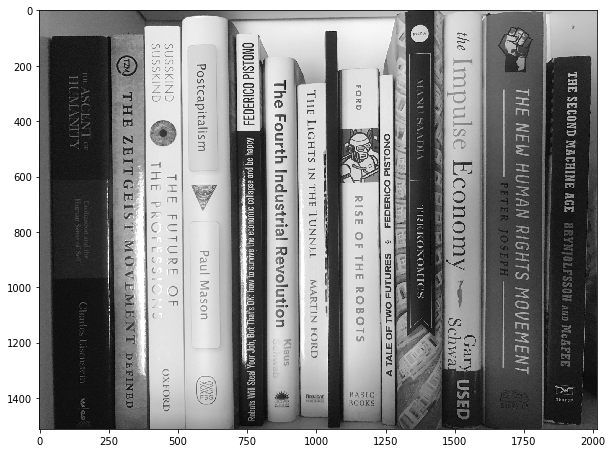

In [8]:
file = './imports/7.jpg'

gray_image = cv2.imread(file, 0)
col_image  = cv2.imread(file)

preview(gray_image, 1)

## 2. Detect correct image orientation 

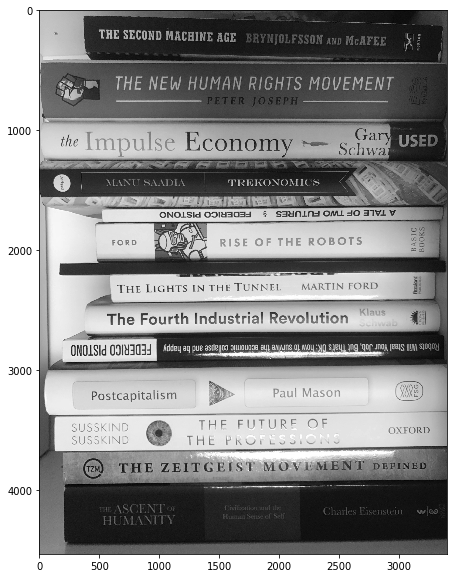

In [20]:

### we are going to dectect which way the image should be rotated 
### to increase the number of books oriented correctly
### this will save us a lot of time in production when crawling 

h = hor_lines(col_image.copy()) ## detect rotation where we have more horizontal lines then vertical
if h[1]>h[0]: 
    col_image  = image_rotate(col_image, 90) 
    gray_image = image_rotate(gray_image, 90)  
    
g = detect_gibberish(col_image.copy()) # now see if we need to rotate 180 based on where we get more gibberish
if g[1]>g[0]: 
    col_image = image_rotate(col_image, 180) 
    gray_image = image_rotate(gray_image, 180)

# scale to the size that works well for detection of lines 

scale = 1
new_width = 3*1512*scale

col_image  = cv2.resize(col_image,  (scale*int(col_image.shape[1]* new_width/col_image.shape[0]), new_width )) 
gray_image = cv2.resize(gray_image, (scale*int(gray_image.shape[1]* new_width/gray_image.shape[0]), new_width )) 


preview(gray_image, 1)

## 3. Detect lines that separate books

11

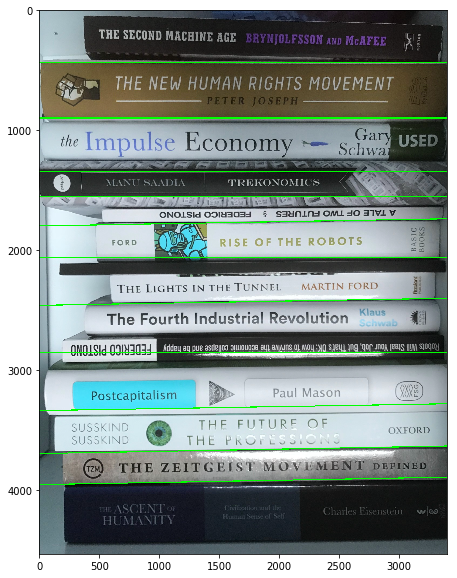

In [12]:
lines_image = col_image.copy()

# -- lines 
lines = lines_detect(lines_image)

### --- filter out short lines (and vertical)

lines_copy = lines.reshape(lines.shape[0],4)
lines_f1 = np.array([line for line in lines_copy if (line[2]-line[0]) > 600])

### sort and then filter by distance

slines = sorted(lines_f1,key=itemgetter(1))

gap = 200 
point = 0
flines = [] # filtered lines

for x in range(0, len(slines)):

    x1,y1,x2,y2 = slines[x]
    if (y1-point)>gap:
        point = y1 
        flines.append(slines[x])


### -- extens lines to edges

for line in range(0, len(flines)):
    
    x1,y1,x2,y2 = flines[line]

    if y2!=y1: 
        
        slope = (y2-y1)/(x2-x1)
        b1 = int(y1 - x1*slope)
        y3 = int((lines_image.shape[1]-1)*slope + b1)

    else:
        b1 = flines[line][1]
        y3 = flines[line][3]
    
    flines[line] = [0,b1,lines_image.shape[1]-1,y3]
        
## preview      
show_lines = lines_image.copy()
show_lines = plot_lines(show_lines, np.array(flines))


preview(show_lines)
len(flines) ## number of  final lines detected 
   

## 4. Cut image into separate books

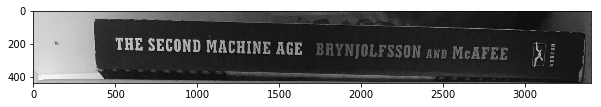

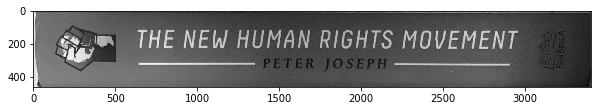

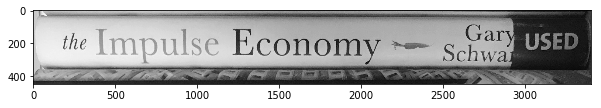

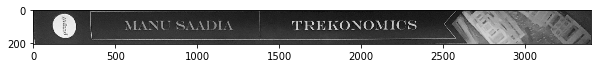

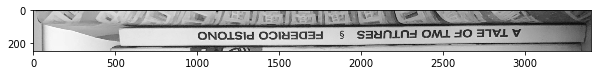

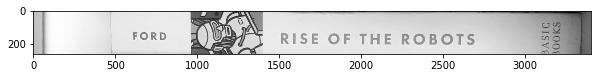

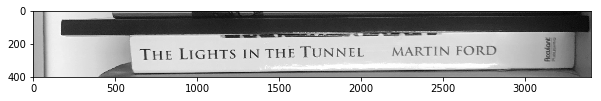

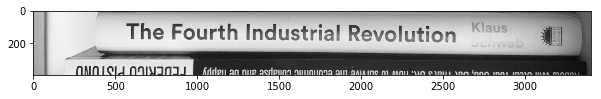

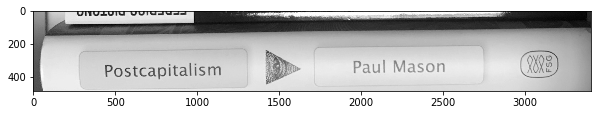

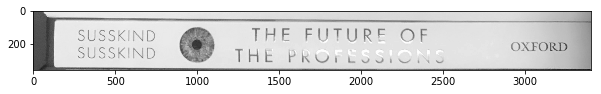

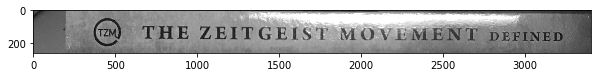

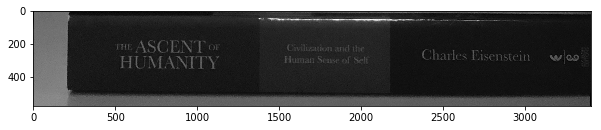

In [13]:
book_images = []

image = gray_image.copy()

for book_n in range(0,len(flines)+1):

    # crop 

    if book_n == 0: t = 0
    else: t = min(flines[book_n-1][1], flines[book_n-1][3])

    if book_n == len(flines): b = image.shape[0]-1
    else: b = max(flines[book_n][3], flines[book_n][1])

    crop = image[t:b, :]

    # find angle
    
    angle = detect_angle(flines[book_n-1])
    if(book_n==0): angle = 0 # *** temporaty fix -- need to get back to this later


    # adjust rotation

    w = crop.shape[1]
    h = crop.shape[0]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(crop, M, (w, h), flags=cv2.INTER_CUBIC)

    # adjust crop 

    adjust = abs(int(math.tan(math.radians(angle))*rotated.shape[1]/2))
    crop_2 = rotated[adjust:rotated.shape[0]-adjust, :]
    
    book_images.append(crop_2)
    
    preview(crop_2, 1)
  

# III. MAIN SECTION: Parse images + crawl Google & Amazon

### Note: this cell will be running for some time. This is where we the main load chromedriver and crawl to get info on books

In [14]:
global items 
global url   
   
## -- load chromedriver
path_to_chromedriver = './imports/chromedriver' # change path as needed
options = webdriver.ChromeOptions() 
options.add_argument('headless')

global driver
# driver = webdriver.Chrome(executable_path = path_to_chromedriver) 
driver = webdriver.Chrome(executable_path = path_to_chromedriver, options = options)  ## headless 

url_set = set() 
items = []
item_id = -1


for bn, book in enumerate(book_images):   
    
    stage = 0 ###   0:normal  1:+equalize  2:+rotate  3:+rotate+equalize
    
    print(" ")
    print("_______________ ")
    print(" ")
    print(" IMAGE # {} :".format(bn))
    print("_______________ ")
    print(" ")
     
    expecting = 0
    n_books = 0  # tracker for how many books we've found
        
    while True:    

        if stage > 3: break  
        
        print(" ")
        print("   >> stage {}".format(stage))
        
        equ = False 
        rotation = False 
        
        if stage in (1,3): 
            equ = True
            print("   + equilization")
        
        if stage in (2,3):
            rotation = True
            print("   + rotate")
        
        parsed = parse_book(book.copy(), equ, rotation) # parse text from an image

        print("   "+str(parsed))
        print(" ")

        lines, expect, empty = parsed_analyze(parsed) # analyze it
        
        if not empty and expecting==0 : ### we take a look at how many books we expect only on the first run 
            
            expecting = expect
            end = ""
            if expect != 1 : end = "s"
            print("   expecting {} book{}".format(expect, end))
        
        elif empty: ## parcing didn't detect any text - advancing to next stage 
            stage +=1
            continue

        lines_copy = lines.copy()
        for x in range(len(lines)):

            found_book = False

            # to reduce number of unnecessary crawls, we start with the longest lines first, 
            # which are more likely to be a title
            _, pos = max([(len(x),i) for i, x in enumerate(lines_copy)])
            line = lines_copy.pop(pos)
            print("   line: {}".format(line))

            found_book = google_search(line) # <<--- the rabbit hole down which all the magic happens
#             print("google search result: {}".format(found_book))
            
            if found_book:
                n_books +=1 
                if n_books >= expect: break
            
        print("   books found: "+str(n_books)) # yay! 
        
        
        if n_books==0: stage+=1; continue ### ** temp - reducing to just one book for now to speed things up.. ;
#         if n_books!=expect: stage+=1; continue

        break ## alright, we did everything we can, calling quits on detecting a book from this image

 
_______________ 
 
 IMAGE # 0 :
_______________ 
 
 
   >> stage 0
   ['THE SECUND MACHINE AGE']
 
   expecting 1 book
   line: THE SECUND MACHINE AGE
   https://www.amazon.com/Second-Machine-Age-Prosperity-Technologies/dp/0393350649
   books found: 1
 
_______________ 
 
 IMAGE # 1 :
_______________ 
 
 
   >> stage 0
   ['ngu THE NEW HUMAN RIGHTS MOVEMENT']
 
   expecting 1 book
   line: ngu THE NEW HUMAN RIGHTS MOVEMENT
   https://www.amazon.com/New-Human-Rights-Movement-Reinventing/dp/1942952651
   books found: 1
 
_______________ 
 
 IMAGE # 2 :
_______________ 
 
 
   >> stage 0
   ['Gar', '', ' ', '', 'Ecopomy Schwa']
 
   expecting 2 books
   line: Ecopomy Schwa
   books found: 0
 
   >> stage 1
   + equilization
   ['the Impn', 'V Ava w', '', 'I']
 
   line: the Impn
   books found: 0
 
   >> stage 2
   + rotate
   ['R BAX qD S', '', '   ', '', 'ix Ambuoag']
 
   line: ix Ambuoag
   books found: 0
 
   >> stage 3
   + equilization
   + rotate
   ['txyr ngv V', '', 'IHLhLll u

# IV. OUTPUT RESULTS

In [17]:
pd.DataFrame(items)

,author,desription,image,img_url,title,type
0,Visit Amazon's Erik Brynjolfsson Page,A New York Times Bestseller. A “fascinating” ...,saved,https://images-na.ssl-images-amazon.com/images...,"The Second Machine Age: Work, Progress, and Pr...",1
1,Visit Amazon's Peter Joseph Page,Society is broken. We can design our way to a...,saved,https://images-na.ssl-images-amazon.com/images...,The New Human Rights Movement: Reinventing the...,1
2,Visit Amazon's Manu Saadia Page,“Saadia proves that Star Trek is an even more...,saved,https://images-na.ssl-images-amazon.com/images...,Trekonomics: The Economics of Star Trek,1
3,Visit Amazon's Federico Pistono Page,A Tale of Two Futures is a sci-fi young adult...,saved,https://images-na.ssl-images-amazon.com/images...,A Tale of Two Futures,1
4,Visit Amazon's Martin Ford Page,What will the economy of the future look like...,saved,https://images-na.ssl-images-amazon.com/images...,"The Lights in the Tunnel: Automation, Accelera...",1
5,Klaus Schwab,"World-renowned economist Klaus Schwab, Founde...",saved,https://images-na.ssl-images-amazon.com/images...,The Fourth Industrial Revolution,1
6,Visit Amazon's Paul Mason Page,We know that our world is undergoing seismic ...,saved,https://images-na.ssl-images-amazon.com/images...,Postcapitalism: A Guide to Our Future,1
7,Richard Susskind,This book predicts the decline of today's pro...,saved,https://images-na.ssl-images-amazon.com/images...,The Future of the Professions: How Technology ...,1


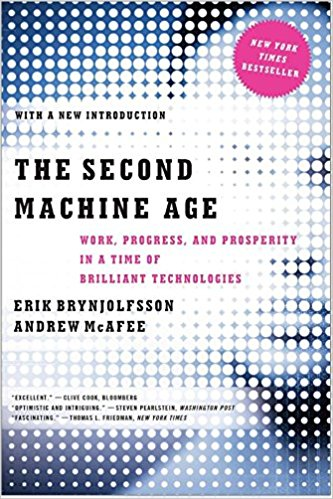

___________________________________________________
 
" The Second Machine Age: Work, Progress, and Prosperity in a Time of Brilliant Technologies "
___________________________________________________
 
author:  Visit Amazon's Erik Brynjolfsson Page
description: 
 A New York Times Bestseller. A “fascinating” (Thomas L. Friedman, New York Times) look at how digital technology is transforming our work and our lives. In recent years, Google’s autonomous cars have logged thousands of miles on American highways and IBM’s Watson trounced the best human Jeopardy! players. Digital technologies―with hardware, software, and networks at their core―will in the near future diagnose diseases more accurately than doctors can, apply enormous data sets to transform retailing, and accomplish many tasks once considered uniquely human. In The Second Machine Age MIT’s Erik Brynjolfsson and Andrew McAfee―two thinkers at the forefront of their field―reveal the forces driving the reinvention of our lives and 

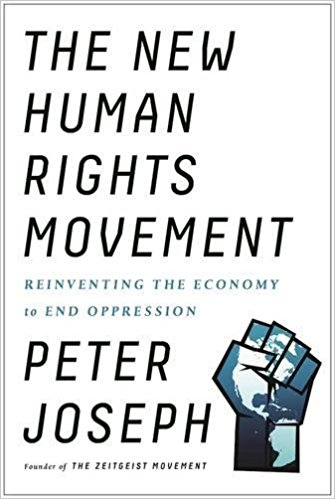

___________________________________________________
 
" The New Human Rights Movement: Reinventing the Economy to End Oppression "
___________________________________________________
 
author:  Visit Amazon's Peter Joseph Page
description: 
 Society is broken. We can design our way to a better one.In our interconnected world, self-interest and social-interest are rapidly becoming indistinguishable. If current negative trajectories remain, including growing climate destabilization, biodiversity loss, and economic inequality, an impending future of ecological collapse and societal destabilization will make "personal success" virtually meaningless. Yet our broken social system incentivizes behavior that will only make our problems worse. If true human rights progress is to be achieved today, it is time we dig deeper―rethinking the very foundation of our social system.In this engaging, important work, Peter Joseph, founder of the world's largest grassroots social movement―The Zeitgeist Mov

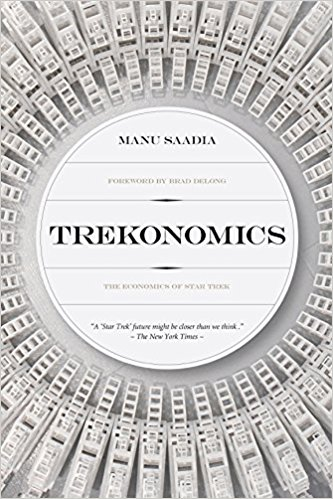

___________________________________________________
 
" Trekonomics: The Economics of Star Trek "
___________________________________________________
 
author:  Visit Amazon's Manu Saadia Page
description: 
 “Saadia proves that Star Trek is an even more valuable cultural icon than we ever suspected.”― Charlie Jane Anders, former editor-in-chief, io9What would the world look like if everybody had everything they wanted or needed? Trekonomics, the first book from financial journalist Felix Salmon's imprint Pipertext, approaches scarcity economics by coming at it backwards ― through thinking about a universe where scarcity does not exist. Delving deep into the details and intricacies of 24th century society, Trekonomics explores post-scarcity and whether we, as humans, are equipped for it. What are the prospects of automation and artificial intelligence? Is there really no money in Star Trek? Is Trekonomics at all possible?
 


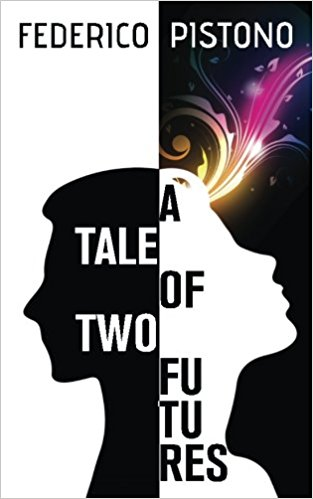

___________________________________________________
 
" A Tale of Two Futures "
___________________________________________________
 
author:  Visit Amazon's Federico Pistono Page
description: 
 A Tale of Two Futures is a sci-fi young adult novella that tells the story of an average day in life in two very different futures, one where things have gone terribly wrong, and the other where things have gone amazingly right. The future will either be beautiful beyond imagination; or dismayingly horrifying, much worse than sci-fi dystopias have prepared us for. The difference between the two futures lies in the choices we make. Most people think that the world is too big, too immense for any individual to have an impact, because anything we do is merely a drop in the ocean. But what is an ocean, if not a multitude of drops?
 


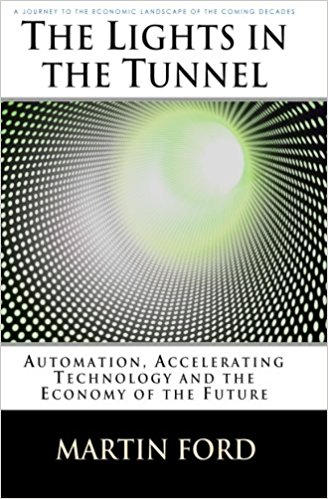

___________________________________________________
 
" The Lights in the Tunnel: Automation, Accelerating Technology and the Economy of the Future "
___________________________________________________
 
author:  Visit Amazon's Martin Ford Page
description: 
 What will the economy of the future look like? Where will advancing technology, job automation, outsourcing and globalization lead? This groundbreaking book by a Silicon Valley computer engineer explores these questions and shows how accelerating technology is likely to have a highly disruptive influence on our economy in the near future--and may well already be a significant factor in the current global crisis. THE LIGHTS IN THE TUNNEL employs a powerful thought experiment to explore the economy of the future. An imaginary "tunnel of lights" is used to visualize the economic implications of the new technologies that are likely to appear in the coming years and decades. The book directly challenges conventional views of the future

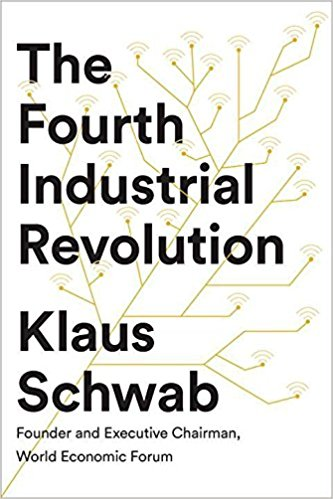

___________________________________________________
 
" The Fourth Industrial Revolution "
___________________________________________________
 
author:  Klaus Schwab
description: 
 World-renowned economist Klaus Schwab, Founder and Executive Chairman of the World Economic Forum, explains that we have an opportunity to shape the fourth industrial revolu&shy;tion, which will fundamentally alter how we live and work. Schwab argues that this revolution is different in scale, scope and complexity from any that have come before. Characterized by a range of new technologies that are fusing the physical, digital and biological worlds, the developments are affecting all disciplines, economies, industries and governments, and even challenging ideas about what it means to be human. Artificial intelligence is already all around us, from supercomputers, drones and virtual assistants to 3D printing, DNA sequencing, smart thermostats, wear&shy;able sensors and microchips smaller than a grain of sand

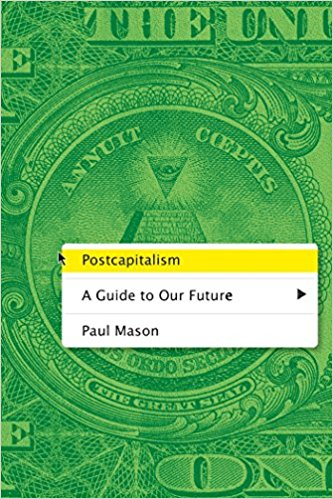

___________________________________________________
 
" Postcapitalism: A Guide to Our Future "
___________________________________________________
 
author:  Visit Amazon's Paul Mason Page
description: 
 We know that our world is undergoing seismic change―but how can we emerge from the crisis a fairer, more equal society?Over the past two centuries or so, capitalism has undergone profound changes―economic cycles that veer from boom to bust―from which it has always emerged transformed and strengthened. Surveying this turbulent history, Paul Mason’s Postcapitalism argues that we are on the brink of a change so big and so profound that this time capitalism itself, the immensely complex system within which entire societies function, will mutate into something wholly new. At the heart of this change is information technology, a revolution that is driven by capitalism but, with its tendency to push the value of much of what we make toward zero, has the potential to destroy an economy based 

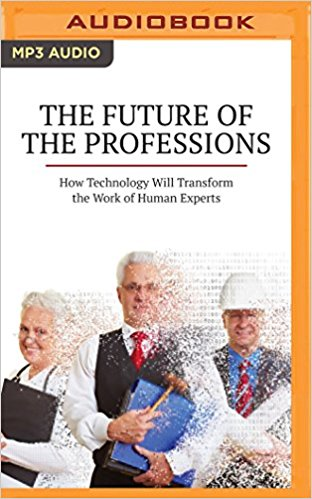

___________________________________________________
 
" The Future of the Professions: How Technology Will Transform the Work of Human Experts "
___________________________________________________
 
author:  Richard Susskind
description: 
 This book predicts the decline of today's professions and describes the people and systems that will replace them. In an Internet society, according to Richard Susskind and Daniel Susskind, we will neither need nor want doctors, teachers, accountants, architects, the clergy, consultants, lawyers, and many others, to work as they did in the 20th century.The Future of the Professions explains how "increasingly capable systems"—from telepresence to artificial intelligence—will bring fundamental change in the way that the "practical expertise" of specialists is made available in society.The authors challenge the "grand bargain"—the arrangement that grants various monopolies to today's professionals. They argue that our current professions are antiquated,

In [23]:
from IPython.display import Image

for i in np.arange(len(items)):

    display(Image(filename='images/'+str(i)+'.jpg'))

    print("___________________________________________________")
    print(" ")
    print('\"',items[i]['title'],'\"')
    print("___________________________________________________")
    print(" ")
    print('author: ',items[i]['author'])
    print('description: ')
    print(items[i]['desription'])

# Ideas to implement next..

1. Need to implement a way for passing/not checking parsed lines again that closely resemble title of any book already discovered. Will save time. \n --> Implement Levenshtein distance


2. create a function that detects line connecting mode of charachter height, to adjust rotation better. 

3. create a funciton that crops image as close to charachter broders with some padding

4. create a good normalization function or a variation on bimodal, perhaps with histogram analysis to detect background 
